In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

c:\Users\malon\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

In [4]:
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [5]:
def get_adversial_exemple(model, image, label, eps=0.25):
    image = tf.cast(image, tf.float32)
    image = tf.expand_dims(image, 0)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    adv_ex = image + eps*signed_grad    
    adv_ex = tf.clip_by_value(adv_ex, 0, 1)
    return adv_ex

In [6]:
# Shallow softmax model

shallow_softmax = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_softmax.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_softmax.fit(ds_train, epochs=5)
shallow_softmax.evaluate(ds_test)

Epoch 1/5
469/469 [==============================] - 2s 1ms/step - loss: 0.6800 - accuracy: 0.8293
Epoch 2/5
469/469 [==============================] - 1s 970us/step - loss: 0.3622 - accuracy: 0.9017
Epoch 3/5
469/469 [==============================] - 0s 891us/step - loss: 0.3195 - accuracy: 0.9122
Epoch 4/5
469/469 [==============================] - 0s 891us/step - loss: 0.2999 - accuracy: 0.9167
Epoch 5/5
79/79 [==============================] - 0s 2ms/step - loss: 0.2797 - accuracy: 0.9219


[0.2796688377857208, 0.9218999743461609]

In [7]:
# Shallow maxout model inspired from https://github.com/philipperemy/tensorflow-maxout/blob/master/mnist_maxout_example.py

shallow_maxout = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(100),
  tfa.layers.Maxout(50),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_maxout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_maxout.fit(ds_train, epochs=5)
shallow_maxout.evaluate(ds_test)

Epoch 1/5
469/469 [==============================] - 1s 2ms/step - loss: 0.3909 - accuracy: 0.8922
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1569 - accuracy: 0.9553
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1156 - accuracy: 0.9667
Epoch 4/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0946 - accuracy: 0.9718
Epoch 5/5
79/79 [==============================] - 0s 1ms/step - loss: 0.0979 - accuracy: 0.9700


[0.09785871207714081, 0.9700000286102295]

In [8]:
# convert tf.data.Dataset to numpy array
x_test = np.concatenate([x for x, y in ds_test], axis=0)
y_test = np.concatenate([y for x, y in ds_test], axis=0)

# avaluate shallow_softmax model on adversarial examples

x_test_adv = [get_adversial_exemple(shallow_softmax, x, y,eps=0.25).numpy()[0] for x,y in zip(x_test, y_test)]
x_test_adv = np.array(x_test_adv)

l,a =  shallow_softmax.evaluate(x_test_adv, y_test)
c = np.mean(np.max(shallow_softmax.predict(x_test_adv), axis=1))
print(f"Accuracy on adversarial examples: {a} with a mean confidence of {c}", )

# evaluate shallow_maxout model on adversarial examples

x_test_adv = [get_adversial_exemple(shallow_maxout, x, y,eps=0.25).numpy()[0] for x,y in zip(x_test, y_test)]
x_test_adv = np.array(x_test_adv)

l,a =  shallow_maxout.evaluate(x_test_adv, y_test)
c = np.mean(np.max(shallow_maxout.predict(x_test_adv), axis=1))
print(f"Accuracy on adversarial examples: {a} with a mean confidence of {c}", )

313/313 [==============================] - 0s 686us/step - loss: 15.2699 - accuracy: 0.0000e+00
Accuracy on adversarial examples: 0.0 with a mean confidence of 0.8864707946777344
313/313 [==============================] - 0s 856us/step - loss: 26.4990 - accuracy: 0.0033
Accuracy on adversarial examples: 0.0032999999821186066 with a mean confidence of 0.9281532168388367


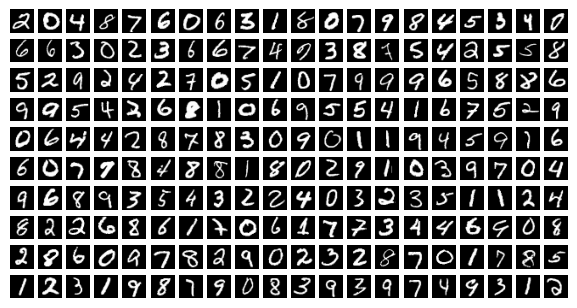

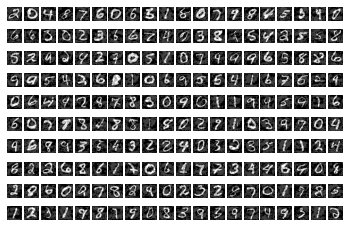

In [9]:
#Afficher les images
import matplotlib.pyplot as plt
plt.figure(figsize=(7.195, 3.841), dpi=100)
plt.figure(1)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(x_test[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')
plt.figure(2)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(x_test_adv[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')

plt.show()

# Régression logistique pour classer 3 et 7
https://github.com/msotaquira/binary-logistic-regression-with-MNIST/blob/master/binary-logistic-regression-MNIST.py

In [10]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#flatten images
x_train = np.reshape( x_train, (x_train.shape[0],x_train.shape[1]*x_train.shape[2]) )
x_test = np.reshape( x_test, (x_test.shape[0],x_test.shape[1]*x_test.shape[2]) )

In [11]:
#keep only 3 and 7
X_train = np.vstack( (x_train[y_train==3], x_train[y_train==7]) )
Y_train = np.hstack( (y_train[y_train==3], y_train[y_train==7]) )
X_test = np.vstack( (x_test[y_test==3], x_test[y_test==7]) )
Y_test = np.hstack( (y_test[y_test==3], y_test[y_test==7]) )

In [12]:
# Shuffle training data and normalize both datasets
permute_indices = np.random.permutation(X_train.shape[0])
X_train = X_train[permute_indices,:]
Y_train = Y_train[permute_indices]

X_train = X_train/255.0
X_test = X_test/255.0

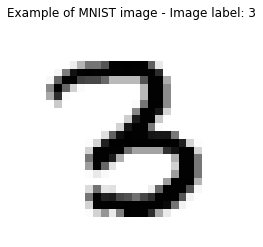

In [13]:
# Dìsplay an example train image
img_number = 18
plt.imshow(X_train[img_number,:].reshape(28,28), cmap="gray_r")
plt.title('Example of MNIST image - Image label: ' + str(Y_train[img_number]))
plt.axis('off')
plt.show()

In [14]:
# Binary (0,1) encoding of 'class_1' as 0 and 'class_2' as 1
Y_train[Y_train==3] = 0
Y_train[Y_train==7] = 1
Y_test[Y_test==3] = 0
Y_test[Y_test==7] = 1

c:\Users\malon\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
13/13 - 0s - loss: 0.6329 - accuracy: 0.6488
Epoch 2/30
13/13 - 0s - loss: 0.4896 - accuracy: 0.8859
Epoch 3/30
13/13 - 0s - loss: 0.4027 - accuracy: 0.9288
Epoch 4/30
13/13 - 0s - loss: 0.3449 - accuracy: 0.9444
Epoch 5/30
13/13 - 0s - loss: 0.3047 - accuracy: 0.9514
Epoch 6/30
13/13 - 0s - loss: 0.2750 - accuracy: 0.9556
Epoch 7/30
13/13 - 0s - loss: 0.2522 - accuracy: 0.9582
Epoch 8/30
13/13 - 0s - loss: 0.2342 - accuracy: 0.9614
Epoch 9/30
13/13 - 0s - loss: 0.2197 - accuracy: 0.9630
Epoch 10/30
13/13 - 0s - loss: 0.2076 - accuracy: 0.9650
Epoch 11/30
13/13 - 0s - loss: 0.1974 - accuracy: 0.9658
Epoch 12/30
13/13 - 0s - loss: 0.1887 - accuracy: 0.9662
Epoch 13/30
13/13 - 0s - loss: 0.1811 - accuracy: 0.9666
Epoch 14/30
13/13 - 0s - loss: 0.1745 - accuracy: 0.9672
Epoch 15/30
13/13 - 0s - loss: 0.1687 - accuracy: 0.9678
Epoch 16/30
13/13 - 0s - loss: 0.1635 - accuracy: 0.9681
Epoch 17/30
13/13 - 0s - loss: 0.1588 - accuracy: 0.9689
Epoch 18/30
13/13 - 0s - loss: 0.1546 - 

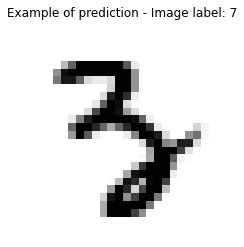

In [15]:
## Build the model

# - Input layer: 784 nodes (since each image has 28x28 = 784 pixels)
# - Output layer: 1 node with sigmoid activation (output labeled as '0' or '1')
# - No hidden layers

np.random.seed(1)		# fix random seed for reproducibility

input_dim = X_train.shape[1]
output_dim = 1 							

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(output_dim, input_dim = input_dim, activation='sigmoid'))

# Compile  and train the model
sgd = tf.keras.optimizers.SGD(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

num_epochs = 30
batch_size = 1024
history = model.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size, verbose=2)

# Evaluate and predict
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test accuracy:', score[1])

Y_pred = model.predict(X_test)

# Plot one example of prediction
img_number = 8
if Y_pred[img_number] == 0.0:
	predicted_class = 3
else:
	predicted_class = 7

plt.imshow(X_test[img_number,:].reshape(28,28), cmap="gray_r")
plt.title('Example of prediction - Image label: ' + str(predicted_class))
plt.axis('off')
plt.show()

In [16]:
X_train_adv = [get_adversial_exemple(shallow_softmax, x, y,eps=0.25).numpy()[0] for x,y in zip(X_train, Y_train)]
X_train_adv = np.array(X_train_adv)
X_test_adv = [get_adversial_exemple(shallow_softmax, x, y,eps=0.25).numpy()[0] for x,y in zip(X_test, Y_test)]
X_test_adv = np.array(X_test_adv)

Epoch 1/30
13/13 - 0s - loss: 0.5108 - accuracy: 0.8805
Epoch 2/30
13/13 - 0s - loss: 0.3311 - accuracy: 0.9822
Epoch 3/30
13/13 - 0s - loss: 0.2431 - accuracy: 0.9894
Epoch 4/30
13/13 - 0s - loss: 0.1925 - accuracy: 0.9914
Epoch 5/30
13/13 - 0s - loss: 0.1601 - accuracy: 0.9921
Epoch 6/30
13/13 - 0s - loss: 0.1376 - accuracy: 0.9923
Epoch 7/30
13/13 - 0s - loss: 0.1212 - accuracy: 0.9923
Epoch 8/30
13/13 - 0s - loss: 0.1088 - accuracy: 0.9925
Epoch 9/30
13/13 - 0s - loss: 0.0990 - accuracy: 0.9927
Epoch 10/30
13/13 - 0s - loss: 0.0910 - accuracy: 0.9927
Epoch 11/30
13/13 - 0s - loss: 0.0844 - accuracy: 0.9928
Epoch 12/30
13/13 - 0s - loss: 0.0789 - accuracy: 0.9928
Epoch 13/30
13/13 - 0s - loss: 0.0742 - accuracy: 0.9928
Epoch 14/30
13/13 - 0s - loss: 0.0701 - accuracy: 0.9927
Epoch 15/30
13/13 - 0s - loss: 0.0666 - accuracy: 0.9931
Epoch 16/30
13/13 - 0s - loss: 0.0635 - accuracy: 0.9931
Epoch 17/30
13/13 - 0s - loss: 0.0607 - accuracy: 0.9931
Epoch 18/30
13/13 - 0s - loss: 0.0582 - 

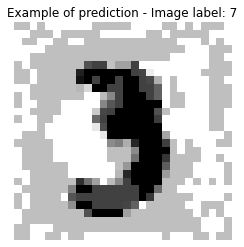

In [19]:
## Build the model

# - Input layer: 784 nodes (since each image has 28x28 = 784 pixels)
# - Output layer: 1 node with sigmoid activation (output labeled as '0' or '1')
# - No hidden layers

np.random.seed(3)		# fix random seed for reproducibility

input_dim = X_train_adv.shape[1]
output_dim = 1 							

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(output_dim, input_dim = input_dim, activation='sigmoid'))

# Compile  and train the model
sgd = tf.keras.optimizers.SGD(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

num_epochs = 30
batch_size = 1024
history = model.fit(X_train_adv, Y_train, epochs=num_epochs, batch_size=batch_size, verbose=2)

# Evaluate and predict
score = model.evaluate(X_test_adv, Y_test, verbose=0) 
print('Test accuracy:', score[1])

Y_pred = model.predict(X_test_adv)

# Plot one example of prediction
img_number = 10
if Y_pred[img_number] == 0.0:
	predicted_class = 3
else:
	predicted_class = 7

plt.imshow(X_test_adv[img_number,:].reshape(28,28), cmap="gray_r")
plt.title('Example of prediction - Image label: ' + str(predicted_class))
plt.axis('off')
plt.show()